<a href="https://colab.research.google.com/github/geomiguelsarmiento/ANOMALIAS/blob/main/anomalias2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install geopandas rasterio rasterstats tqdm --quiet

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22.2/22.2 MB 62.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17.3/17.3 MB 75.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.mask import mask
from tqdm.auto import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


base_dir   = '/content/drive/MyDrive/RASTERPRUEBA'     # carpeta del proyecto
raster_fp  = os.path.join(base_dir, '/content/drive/MyDrive/RASTERPRUEBA/ndvi9junnaranjo.tif')
shp_fp     = os.path.join(base_dir, '/content/drive/MyDrive/RASTERPRUEBA/naranjo.shp')
out_fp     = os.path.join(base_dir, '/content/drive/MyDrive/RASTERPRUEBA/zscorendvi9junnaranjo.tif')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
src   = rasterio.open(raster_fp)
meta  = src.meta.copy()          # para el raster de salida
meta.update(dtype='float32', nodata=np.nan)

gdf   = gpd.read_file(shp_fp).to_crs(src.crs)   # aseguramos mismo CRS

In [ ]:
# Se crear√° un array lleno con NaN (mismo tama√±o que el raster original)
z_arr = np.full((src.height, src.width), np.nan, dtype='float32')
nodata_val = src.nodata

In [ ]:
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Procesando pol√≠gonos'):
    geom = [row.geometry]                      # rasterio espera una lista

    # a) Extraer solo los p√≠xeles del pol√≠gono
    sub_arr, sub_transform = mask(src, geom, crop=False, nodata=nodata_val)
    sub_arr = sub_arr[0]                       # quitamos dimensi√≥n de banda

    # b) Calculamos estad√≠sticos ignorando nodata/NaN
    pix_vals = sub_arr[sub_arr != nodata_val]
    if pix_vals.size == 0:
        continue                               # pol√≠gono vac√≠o
    mean = pix_vals.mean()
    std  = pix_vals.std()
    if std == 0:                               # valores constantes
        continue

    # c) Z-score local
    z_local = (sub_arr - mean) / std

    # d) Colocamos los resultados en el array global
    mask_bool = (sub_arr != nodata_val)
    z_arr[mask_bool] = z_local[mask_bool]

Procesando pol√≠gonos:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-3895549373.py:18: RuntimeWarning: overflow encountered in divide
  z_local = (sub_arr - mean) / std
/tmp/ipython-input-13-38

In [ ]:
with rasterio.open(out_fp, 'w', **meta) as dst:
    dst.write(z_arr, 1)
print('‚úÖ Raster z-score guardado en:', out_fp)

‚úÖ Raster z-score guardado en: /content/drive/MyDrive/RASTERPRUEBA/zscorendvi9junnaranjo.tif


(np.float64(-0.5), np.float64(539.5), np.float64(690.5), np.float64(-0.5))

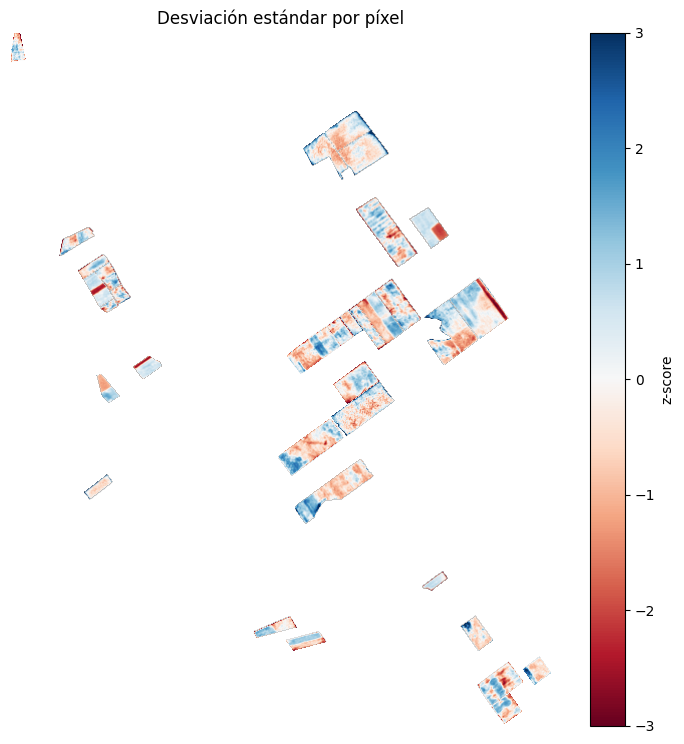

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.imshow(z_arr, cmap='RdBu', vmin=-3, vmax=3)
plt.colorbar(label='z-score')
plt.title('Desviaci√≥n est√°ndar por p√≠xel')
plt.axis('off')

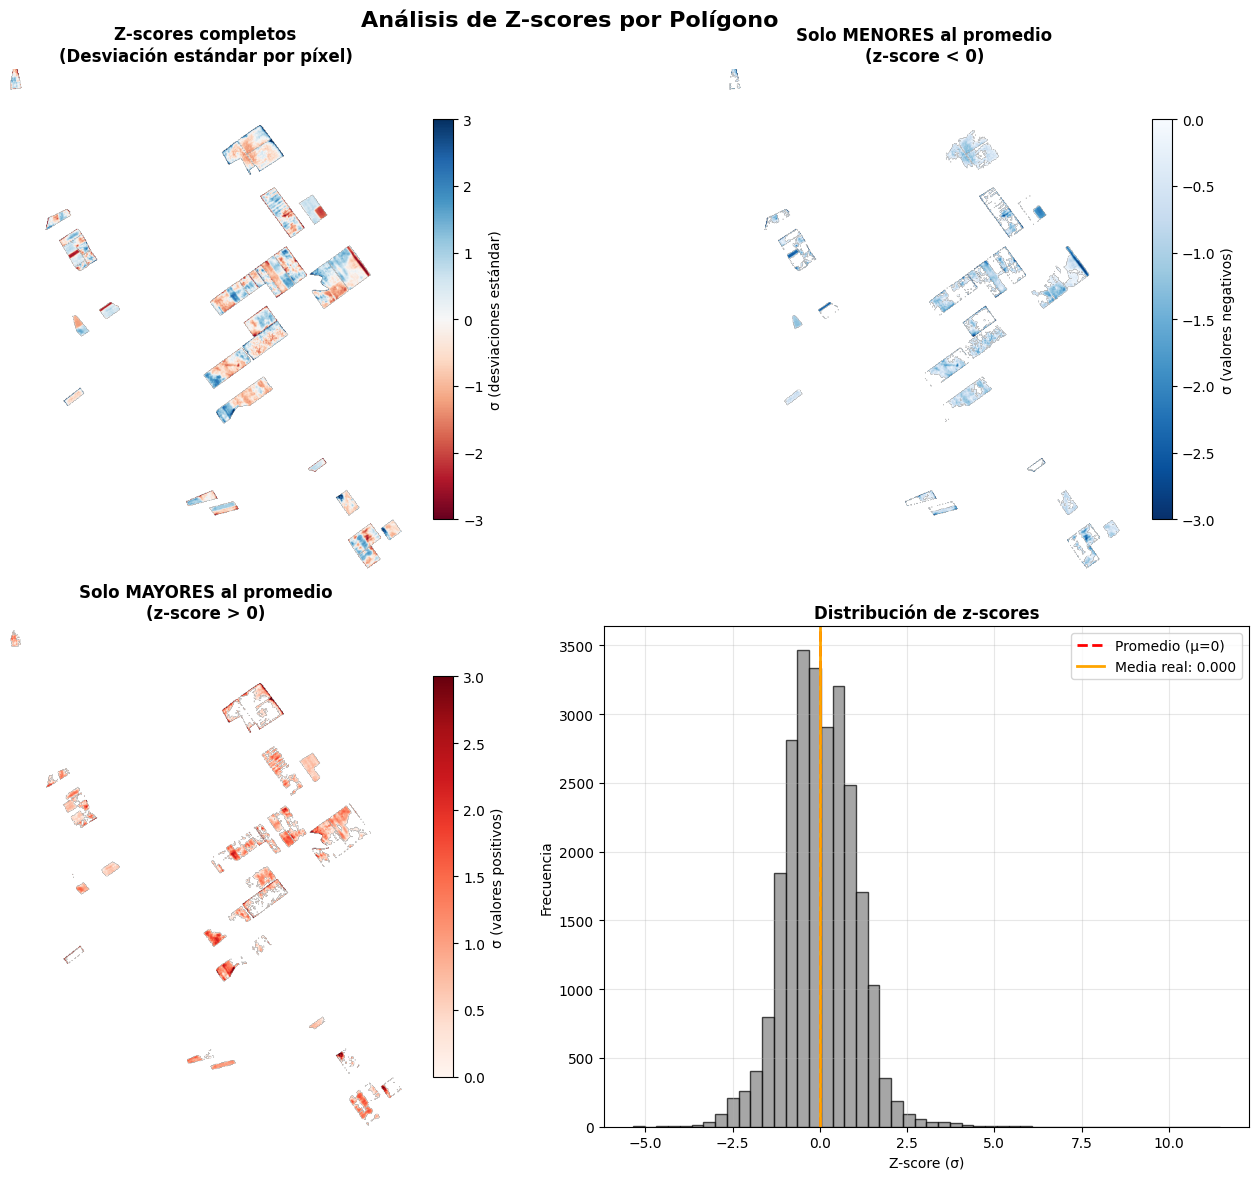

üìä ESTAD√çSTICAS RESUMIDAS:
Total de p√≠xeles v√°lidos: 25,446
Media de z-scores: 0.0000
Desviaci√≥n est√°ndar: 1.0000
Rango: [-5.35, 11.46]

Distribuci√≥n por categor√≠as:
  ‚Ä¢ z < -2œÉ (muy bajo):  619 p√≠xeles (2.4%)
  ‚Ä¢ -2œÉ ‚â§ z < -1œÉ:       2,947 p√≠xeles (11.6%)
  ‚Ä¢ -1œÉ ‚â§ z < 0:         9,483 p√≠xeles (37.3%)
  ‚Ä¢ 0 ‚â§ z < 1œÉ:          8,607 p√≠xeles (33.8%)
  ‚Ä¢ 1œÉ ‚â§ z < 2œÉ:         3,297 p√≠xeles (13.0%)
  ‚Ä¢ z ‚â• 2œÉ (muy alto):   493 p√≠xeles (1.9%)


In [ ]:
import matplotlib.pyplot as plt

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Z-scores completos (arriba izquierda)
im1 = axes[0,0].imshow(z_arr, cmap='RdBu', vmin=-3, vmax=3)
axes[0,0].set_title('Z-scores completos\n(Desviaci√≥n est√°ndar por p√≠xel)', fontsize=12, fontweight='bold')
axes[0,0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('œÉ (desviaciones est√°ndar)', fontsize=10)

# 2. Solo menores al promedio (arriba derecha)
im2 = axes[0,1].imshow(z_menores, cmap='Blues_r', vmin=-3, vmax=0)
axes[0,1].set_title('Solo MENORES al promedio\n(z-score < 0)', fontsize=12, fontweight='bold')
axes[0,1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('œÉ (valores negativos)', fontsize=10)

# 3. Solo mayores al promedio (abajo izquierda)
im3 = axes[1,0].imshow(z_mayores, cmap='Reds', vmin=0, vmax=3)
axes[1,0].set_title('Solo MAYORES al promedio\n(z-score > 0)', fontsize=12, fontweight='bold')
axes[1,0].axis('off')
cbar3 = plt.colorbar(im3, ax=axes[1,0], shrink=0.8)
cbar3.set_label('œÉ (valores positivos)', fontsize=10)

# 4. Histograma de distribuci√≥n (abajo derecha)
z_vals_clean = z_arr[~np.isnan(z_arr)]
axes[1,1].hist(z_vals_clean, bins=50, alpha=0.7, color='gray', edgecolor='black')
axes[1,1].axvline(0, color='red', linestyle='--', linewidth=2, label='Promedio (Œº=0)')
axes[1,1].axvline(z_vals_clean.mean(), color='orange', linestyle='-', linewidth=2,
                  label=f'Media real: {z_vals_clean.mean():.3f}')
axes[1,1].set_xlabel('Z-score (œÉ)', fontsize=10)
axes[1,1].set_ylabel('Frecuencia', fontsize=10)
axes[1,1].set_title('Distribuci√≥n de z-scores', fontsize=12, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Ajustar espaciado
plt.tight_layout()
plt.suptitle('An√°lisis de Z-scores por Pol√≠gono', fontsize=16, fontweight='bold', y=0.98)
plt.subplots_adjust(top=0.93)
plt.show()

# Estad√≠sticas resumidas
print("üìä ESTAD√çSTICAS RESUMIDAS:")
print("="*50)
print(f"Total de p√≠xeles v√°lidos: {len(z_vals_clean):,}")
print(f"Media de z-scores: {z_vals_clean.mean():.4f}")
print(f"Desviaci√≥n est√°ndar: {z_vals_clean.std():.4f}")
print(f"Rango: [{z_vals_clean.min():.2f}, {z_vals_clean.max():.2f}]")
print()
print("Distribuci√≥n por categor√≠as:")
print(f"  ‚Ä¢ z < -2œÉ (muy bajo):  {np.sum(z_vals_clean < -2):,} p√≠xeles ({100*np.sum(z_vals_clean < -2)/len(z_vals_clean):.1f}%)")
print(f"  ‚Ä¢ -2œÉ ‚â§ z < -1œÉ:       {np.sum((z_vals_clean >= -2) & (z_vals_clean < -1)):,} p√≠xeles ({100*np.sum((z_vals_clean >= -2) & (z_vals_clean < -1))/len(z_vals_clean):.1f}%)")
print(f"  ‚Ä¢ -1œÉ ‚â§ z < 0:         {np.sum((z_vals_clean >= -1) & (z_vals_clean < 0)):,} p√≠xeles ({100*np.sum((z_vals_clean >= -1) & (z_vals_clean < 0))/len(z_vals_clean):.1f}%)")
print(f"  ‚Ä¢ 0 ‚â§ z < 1œÉ:          {np.sum((z_vals_clean >= 0) & (z_vals_clean < 1)):,} p√≠xeles ({100*np.sum((z_vals_clean >= 0) & (z_vals_clean < 1))/len(z_vals_clean):.1f}%)")
print(f"  ‚Ä¢ 1œÉ ‚â§ z < 2œÉ:         {np.sum((z_vals_clean >= 1) & (z_vals_clean < 2)):,} p√≠xeles ({100*np.sum((z_vals_clean >= 1) & (z_vals_clean < 2))/len(z_vals_clean):.1f}%)")
print(f"  ‚Ä¢ z ‚â• 2œÉ (muy alto):   {np.sum(z_vals_clean >= 2):,} p√≠xeles ({100*np.sum(z_vals_clean >= 2)/len(z_vals_clean):.1f}%)")

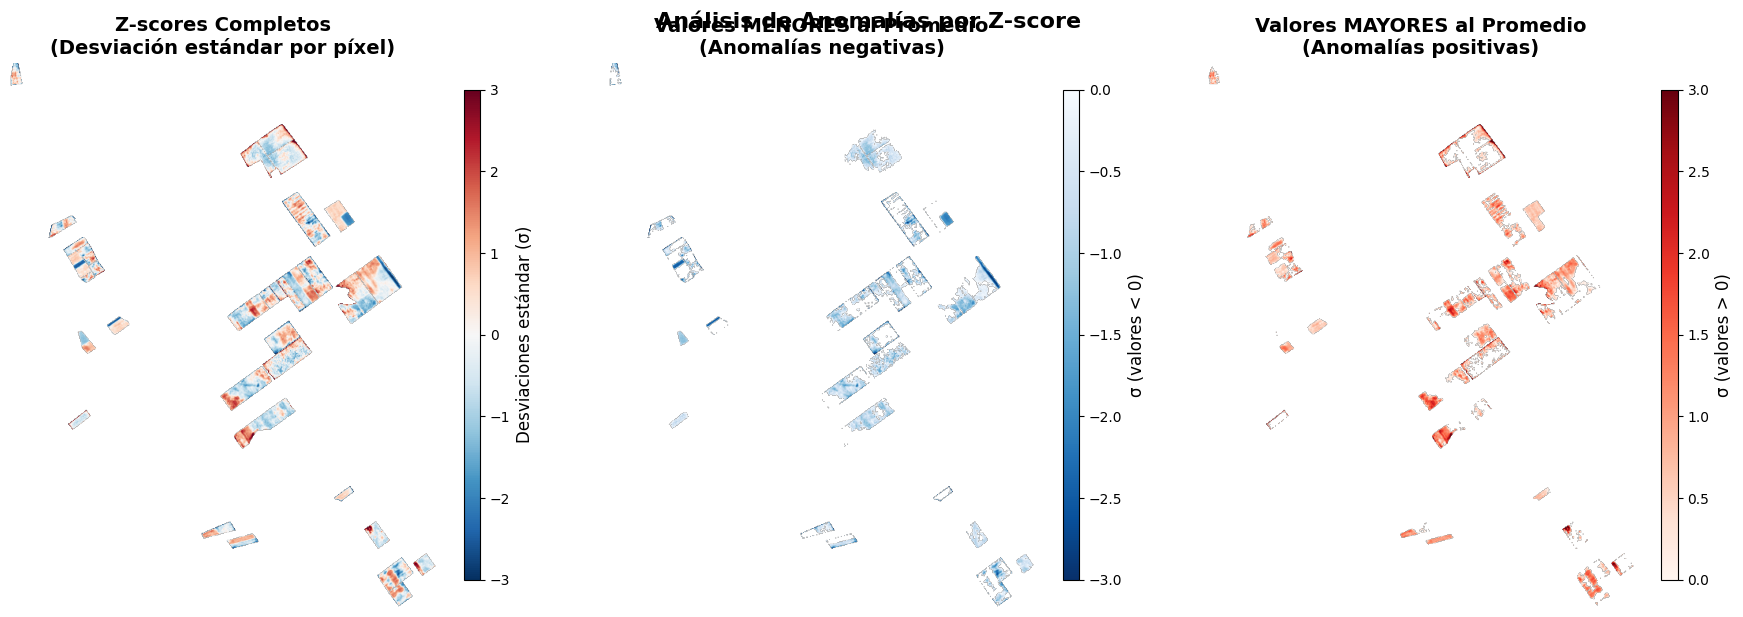

In [ ]:
# Visualizaci√≥n alternativa - Solo mapas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Z-scores completos
im1 = axes[0].imshow(z_arr, cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].set_title('Z-scores Completos\n(Desviaci√≥n est√°ndar por p√≠xel)', fontsize=14, fontweight='bold')
axes[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.9, aspect=30)
cbar1.set_label('Desviaciones est√°ndar (œÉ)', fontsize=12)

# Solo menores
im2 = axes[1].imshow(z_menores, cmap='Blues_r', vmin=-3, vmax=0)
axes[1].set_title('Valores MENORES al Promedio\n(Anomal√≠as negativas)', fontsize=14, fontweight='bold')
axes[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.9, aspect=30)
cbar2.set_label('œÉ (valores < 0)', fontsize=12)

# Solo mayores
im3 = axes[2].imshow(z_mayores, cmap='Reds', vmin=0, vmax=3)
axes[2].set_title('Valores MAYORES al Promedio\n(Anomal√≠as positivas)', fontsize=14, fontweight='bold')
axes[2].axis('off')
cbar3 = plt.colorbar(im3, ax=axes[2], shrink=0.9, aspect=30)
cbar3.set_label('œÉ (valores > 0)', fontsize=12)

plt.tight_layout()
plt.suptitle('An√°lisis de Anomal√≠as por Z-score', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [ ]:
!pip install h3 geopandas rasterio shapely tqdm --quiet

In [ ]:
# --- Convierte cada p√≠xel v√°lido a H3 ---
h3_dict = {}
for row in tqdm(range(src.height), desc="Teselando raster"):
    for col in range(src.width):
        val = arr[row, col]
        if np.isnan(val):
            continue
        x, y = rasterio.transform.xy(transform, row, col)
        lon, lat = rio_transform(src.crs, 'EPSG:4326', [x], [y])
        # ‚úÖ Funci√≥n corregida
        h = h3.latlng_to_cell(lat[0], lon[0], best_res)
        h3_dict[h] = val

print(f"Total de hex√°gonos H3 generados: {len(h3_dict)}")

# --- Crea GeoDataFrame de hex√°gonos ---
def h3_to_polygon(h):
    # ‚úÖ Funci√≥n corregida
    boundary = h3.cell_to_boundary(h)
    # Convertir (lat, lon) a (lon, lat) para Shapely
    boundary_lonlat = [(lon, lat) for lat, lon in boundary]
    return Polygon(boundary_lonlat)

gdf = gpd.GeoDataFrame(
    {'h3_index': list(h3_dict.keys()), 'zscore': list(h3_dict.values())},
    geometry=[h3_to_polygon(h) for h in h3_dict.keys()],
    crs='EPSG:4326'
)

Teselando raster:   0%|          | 0/691 [00:00<?, ?it/s]

Total de hex√°gonos H3 generados: 7714


In [ ]:
# Upgrade or reinstall the h3 library to ensure geo_to_h3 is available
!pip install h3 --upgrade --quiet

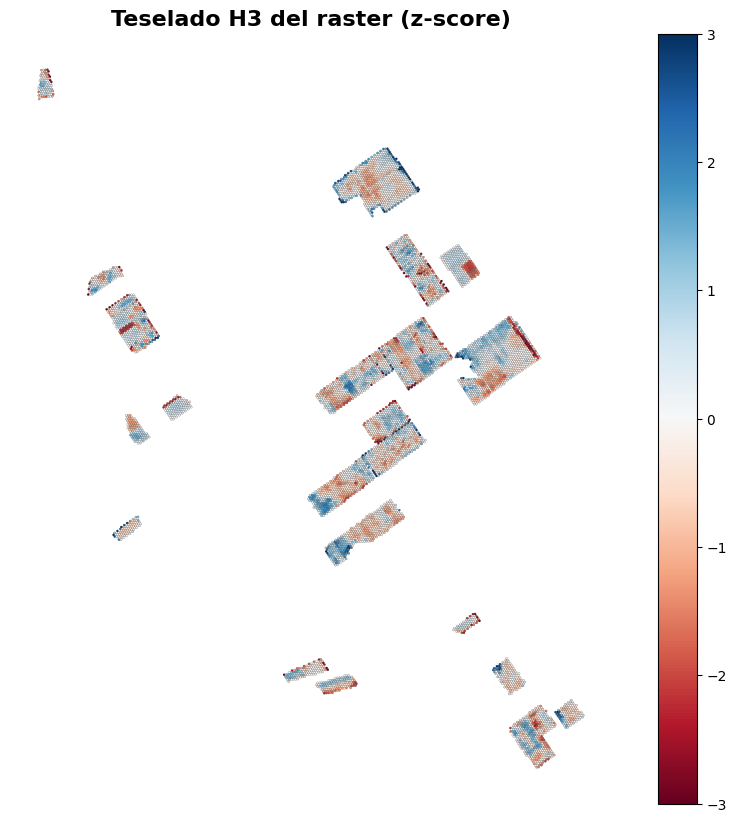

In [ ]:
import matplotlib.pyplot as plt

# Visualizaci√≥n b√°sica
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(
    column='zscore',
    cmap='RdBu',
    legend=True,
    ax=ax,
    edgecolor='k',
    linewidth=0.1,
    vmin=-3, vmax=3  # Ajusta el rango seg√∫n tus datos
)
ax.set_title('Teselado H3 del raster (z-score)', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.show()

In [ ]:
# Exporta a Shapefile
out_shp = raster_fp.replace('.tif', '_h3.shp')
gdf.to_file(out_shp, driver='ESRI Shapefile')
print(f"‚úÖ Shapefile guardado en: {out_shp}")

‚úÖ Shapefile guardado en: /content/drive/MyDrive/RASTERPRUEBA/zscorendvi9junnaranjo_h3.shp
